In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
from tqdm import tqdm
from sklearn.utils import shuffle 
import cv2
import os
import glob
import operator

### Get data

In [24]:
# convert video to imgs
vidcap = cv2.VideoCapture('/Users/xueguoliang/Desktop/data/VideoRecording-2017-06-20-21-53-44.mp4')
vidcap.set(cv2.CAP_PROP_POS_MSEC,5000)
success,image = vidcap.read()
count = 0
success = True
while success:
    success,image = vidcap.read()
    #rotation
    num_rows, num_cols = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), -90, 1)
    img_rotation = cv2.warpAffine(image, rotation_matrix, (num_cols, num_rows))
    #crop the image to get the facial region
    img = img_rotation[50:400,150:350]
    cv2.imwrite("converted/frame{}.jpg".format(count), img)     # save frame as JPEG file
    count += 1

AttributeError: 'NoneType' object has no attribute 'shape'

In [43]:
# convert imgs to array
dirname = "/Users/xueguoliang/myGithub/affective computing/converted"

# Load every image file in the provided directory
filenames = [os.path.join(dirname, fname)
             for fname in os.listdir(dirname) if fname.split(".")[1] == 'jpg']

# Make sure we have exactly 100 image files!
filenames_100 = filenames[:100]
assert(len(filenames_100) == 100)
# Read every filename as an RGB image
imgs = [plt.imread(fname,)[..., :3] for fname in filenames_100]
# Then resize the square image to 48 x 48 pixels
imgs = [cv2.resize(img_i, (48, 48)) for img_i in imgs]
# Finally make our list of 3-D images a 4-D array with the first dimension the number of images:
imgs = np.array(imgs).astype(np.float32)
print (imgs)

[[[[ 247.  227.  205.]
   [ 244.  226.  204.]
   [ 243.  225.  205.]
   ..., 
   [ 211.  188.  172.]
   [ 216.  192.  165.]
   [ 214.  189.  168.]]

  [[ 249.  231.  209.]
   [ 246.  229.  209.]
   [ 245.  228.  208.]
   ..., 
   [ 212.  187.  165.]
   [ 212.  187.  165.]
   [ 213.  189.  164.]]

  [[ 250.  233.  216.]
   [ 249.  232.  213.]
   [ 248.  231.  213.]
   ..., 
   [ 213.  188.  166.]
   [ 214.  188.  164.]
   [ 213.  189.  163.]]

  ..., 
  [[  23.   18.   24.]
   [  26.   21.   27.]
   [  21.   16.   22.]
   ..., 
   [  14.   10.   16.]
   [  14.    9.   14.]
   [  14.    9.   13.]]

  [[  18.   13.   19.]
   [  20.   15.   22.]
   [  17.   12.   19.]
   ..., 
   [  15.   10.   16.]
   [  14.    9.   15.]
   [  13.    8.   12.]]

  [[  18.   13.   19.]
   [  19.   12.   19.]
   [  18.   11.   18.]
   ..., 
   [  14.    9.   15.]
   [  10.    8.   11.]
   [  12.    7.   11.]]]


 [[[ 247.  227.  205.]
   [ 244.  226.  204.]
   [ 243.  225.  205.]
   ..., 
   [ 213.  189.  1

### Model building

In [2]:
def getData(balance_ones=True):
    # images are 48x48 = 2304 size vectors
    # N = 35887
    Y_train = []
    X_train = []
    
    Y_test = []
    X_test = []
    
    first = True
   
    #init length of one-hot vector
    n_labels = 7
    
    for line in open('fer2013/fer2013.csv'):
        if first:
            first = False
        else:
            row = line.split(',')
            if row[2].strip()=="Training":
                Y_train.append(int(row[0]))
                X_train.append([int(p) for p in row[1].split()])
            elif row[2].strip()=="PublicTest":
                Y_test.append(int(row[0]))
                X_test.append([int(p) for p in row[1].split()])
                            
    X_train, Y_train = np.array(X_train) / 255.0, np.array(Y_train)
    X_test, Y_test = np.array(X_test) / 255.0, np.array(Y_test)
        
    return X_train, Y_train, X_test, Y_test

In [3]:
X_train, Y_train, X_test, Y_test = getData()

In [10]:
cv2.imshow((X_train[0]*255).reshape(48,48), cmap='hot')

TypeError: Required argument 'mat' (pos 2) not found

In [4]:
N = len(X_train)
N_test = len(X_test)
print (N, N_test)

28709 3589


#### Input Parameters

In [5]:
# Facial images are 48 pixels in each dimension.
img_size = 48

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes
num_classes = 7  # 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

#### configuration of neural network

In [6]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

#### Plot image

In [7]:
def plot_images(images, cls_true, cls_pred=None):
    
    liter = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape) , cmap='hot')

        # Show true and predicted classes.
        if cls_pred is None: 
            xlabel = "True: {0}".format(liter[cls_true[i]])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

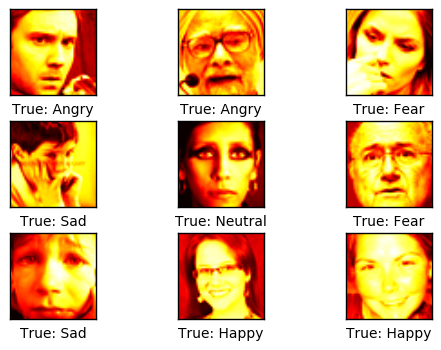

In [13]:
# Get the first images from the test-set.
faces = X[0:9]

# Get the true classes for those images.
cls_true = Y[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=faces, cls_true=cls_true)

#### Build of CNN

In [8]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [9]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [10]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [11]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

#### Placeholder

In [12]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, 7], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

#### Convolutional Layers

In [13]:
layer_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                            num_input_channels=num_channels,
                                            filter_size=filter_size1,
                                            num_filters=num_filters1,
                                            use_pooling=True)
  
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 24, 24, 16) dtype=float32>

In [14]:
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1,
                                            num_input_channels=num_filters1,
                                            filter_size=filter_size2,
                                            num_filters=num_filters2,
                                            use_pooling=True)
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 12, 12, 36) dtype=float32>

#### Flatten Layer

In [15]:
layer_flat, num_features = flatten_layer(layer_conv2)
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 5184) dtype=float32>

In [22]:
num_features

5184

#### Fully Connected Layers

In [16]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [17]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 7) dtype=float32>

#### Predicted Class

In [18]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)

#### Cost Function to be Optimezed

In [19]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#### Execution

In [20]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [21]:
train_batch_size = 64
n_batches = N // train_batch_size

# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations, X, Y):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        
        X, Y = shuffle(X, Y)
        for j in tqdm(range(n_batches)):
            x_batch = X[j*train_batch_size:(j*train_batch_size+train_batch_size)]
            ys = Y[j*train_batch_size:(j*train_batch_size+train_batch_size)] 

            #convert to one-hot
            y_true_batch = []
            for y in ys:
                tmp = [0.,0.,0.,0.,0.,0.,0.]
                tmp[y] = 1
                y_true_batch.append(tmp)
                
            y_true_batch = np.array(y_true_batch)
            #print (y_true_batch)
            # Put the batch into a dict with the proper names
            # for placeholder variables in the TensorFlow graph.
            feed_dict_train = {x: x_batch,
                               y_true: y_true_batch}

            # Run the optimizer using this batch of training data.
            # TensorFlow assigns the variables in feed_dict_train
            # to the placeholder variables and then runs the optimizer.
            session.run(optimizer, feed_dict=feed_dict_train)

            # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [23]:
optimize(95, X_train, Y_train)

100%|██████████| 448/448 [02:03<00:00,  3.70it/s]

Time usage: 6:37:16


In [31]:
# convert imgs to array
dirname = "/Users/xueguoliang/myGithub/affective computing/converted"

# Load every image file in the provided directory
filenames = [os.path.join(dirname, fname)
             for fname in os.listdir(dirname) if fname.split(".")[1] == 'jpg']

# Make sure we have exactly 100 image files!
filenames_100 = filenames[:100]
assert(len(filenames_100) == 100)
# Read every filename as an RGB image
imgs = [plt.imread(fname)[..., :3] for fname in filenames_100]
# Then resize the square image to 48 x 48 pixels
imgs = [cv2.resize(img_i, (48, 48)) for img_i in imgs]
# Finally make our list of 3-D images a 4-D array with the first dimension the number of images:
imgs = np.array(imgs).astype(np.float32)

In [34]:
print (imgs[0][0][0])

[ 247.  227.  205.]


In [ ]:
feed_dict = {x: [your_image]}
classification = tf.run(y_pred_cls, feed_dict)
print classification

In [ ]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(X_test)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = X_test[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

Tensor("ArgMax_1:0", shape=(?,), dtype=int64)


In [38]:
print_test_accuracy()

NameError: name 'print_test_accuracy' is not defined